In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-01-14 23:20:42--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   199MB/s    in 0.4s    

2022-01-14 23:20:43 (199 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

In [2]:
import pandas as pd

In [3]:
! wget https://raw.githubusercontent.com/LuisFGarciaM/PPARg-QSAR/main/PPARg_bioactivity_data_preprocessed.csv

--2022-01-14 23:32:58--  https://raw.githubusercontent.com/LuisFGarciaM/PPARg-QSAR/main/PPARg_bioactivity_data_preprocessed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 354169 (346K) [text/plain]
Saving to: ‘PPARg_bioactivity_data_preprocessed.csv’

PPARg_bioactivity_d 100%[===================>] 345.87K  --.-KB/s    in 0.02s   

2022-01-14 23:32:58 (13.8 MB/s) - ‘PPARg_bioactivity_data_preprocessed.csv’ saved [354169/354169]



In [6]:
df = pd.read_csv('PPARg_bioactivity_data_preprocessed.csv')


Calculate Lipinski descriptors

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

    Molecular weight < 500 Dalton
    Octanol-water partition coefficient (LogP) < 5
    Hydrogen bond donors < 5
    Hydrogen bond acceptors < 10



In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [9]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [10]:
df_lipinski = lipinski(df.canonical_smiles)

In [11]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,461.558,4.90000,2.0,4.0
1,437.458,5.07750,2.0,3.0
2,519.663,7.42680,1.0,6.0
3,512.027,6.95680,1.0,6.0
4,357.435,2.49090,1.0,6.0
...,...,...,...,...
3920,357.435,2.49090,1.0,6.0
3921,514.466,6.90580,1.0,4.0
3922,480.914,6.54040,1.0,4.0
3923,471.479,5.75868,1.0,5.0


In [27]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [28]:
df_combined

,molecule_chembl_id,canonical_smiles,bioactivity_class,value_uM,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL118483,CCC(Cc1ccc(OC)c(C(=O)NCc2ccc(OCCc3ccccc3)cc2)c...,Full Agonist,3.00000,461.558,4.90000,2.0,4.0
1,CHEMBL331206,CCCCC(Cc1ccc(OC)c(C(=O)NCc2ccc(C(F)(F)F)cc2)c1...,Full Agonist,2.50000,437.458,5.07750,2.0,3.0
2,CHEMBL94496,CCCc1cc(Oc2ccc(C(C)C)cc2)ccc1OCCCOc1cccc(C2SC(...,Full Agonist,0.16700,519.663,7.42680,1.0,6.0
3,CHEMBL420441,CCCc1cc(Oc2ccc(Cl)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,Full Agonist,0.16500,512.027,6.95680,1.0,6.0
4,CHEMBL121,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,Full Agonist,0.02000,357.435,2.49090,1.0,6.0
...,...,...,...,...,...,...,...,...
3920,CHEMBL121,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,Full Agonist,0.01800,357.435,2.49090,1.0,6.0
3921,CHEMBL4648903,C[C@H](CCCOc1ccccc1Cn1c(C(F)(F)F)cnc1-c1ccc(C(...,Partial Agonist,100.00001,514.466,6.90580,1.0,4.0
3922,CHEMBL4639259,C[C@H](CCCOc1ccccc1Cn1c(Cl)cnc1-c1ccc(C(F)(F)F...,Partial Agonist,100.00001,480.914,6.54040,1.0,4.0
3923,CHEMBL4647502,C[C@H](CCCOc1ccccc1Cn1c(C(F)(F)F)cnc1-c1ccc(C#...,Partial Agonist,100.00001,471.479,5.75868,1.0,5.0


Convert EC50 to pEC50

To allow EC50 data to be more uniformly distributed, we will convert EC50 to the negative logarithmic scale which is essentially -log10(EC50).

This custom function pEC50() will accept a DataFrame as input and will:

    Take the EC50 values from the value_uM column and converts it from nM to M 

Take the molar value and apply -log10
Delete the value_uM column and create a new pEC50 column

In [29]:
import numpy as np

def pEC50(input):
    pEC50 = []

    for i in input['value_uM_norm']:
        molar = i*(10**-6) # Converts uM to M
        pEC50.append(-np.log10(molar))

    input['pEC50'] = pEC50
    x = input.drop('value_uM_norm', 1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [30]:
df_combined.value_uM.describe()

count    3.925000e+03
mean     6.373782e+00
std      3.205927e+01
min      1.000000e-07
25%      9.500001e-02
50%      8.450000e-01
75%      5.000000e+00
max      1.450000e+03
Name: value_uM, dtype: float64

In [31]:
-np.log10( (10**-9)* 100000000 )

1.0

In [19]:


-np.log10( (10**-9)* 10000000000 )



-1.0

In [32]:
def norm_value(input):
    norm = []

    for i in input['value_uM']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['value_uM_norm'] = norm
    x = input.drop('value_uM', 1)
        
    return x

In [33]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,value_uM_norm
0,CHEMBL118483,CCC(Cc1ccc(OC)c(C(=O)NCc2ccc(OCCc3ccccc3)cc2)c...,Full Agonist,461.558,4.90000,2.0,4.0,3.00000
1,CHEMBL331206,CCCCC(Cc1ccc(OC)c(C(=O)NCc2ccc(C(F)(F)F)cc2)c1...,Full Agonist,437.458,5.07750,2.0,3.0,2.50000
2,CHEMBL94496,CCCc1cc(Oc2ccc(C(C)C)cc2)ccc1OCCCOc1cccc(C2SC(...,Full Agonist,519.663,7.42680,1.0,6.0,0.16700
3,CHEMBL420441,CCCc1cc(Oc2ccc(Cl)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,Full Agonist,512.027,6.95680,1.0,6.0,0.16500
4,CHEMBL121,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,Full Agonist,357.435,2.49090,1.0,6.0,0.02000
...,...,...,...,...,...,...,...,...
3920,CHEMBL121,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,Full Agonist,357.435,2.49090,1.0,6.0,0.01800
3921,CHEMBL4648903,C[C@H](CCCOc1ccccc1Cn1c(C(F)(F)F)cnc1-c1ccc(C(...,Partial Agonist,514.466,6.90580,1.0,4.0,100.00001
3922,CHEMBL4639259,C[C@H](CCCOc1ccccc1Cn1c(Cl)cnc1-c1ccc(C(F)(F)F...,Partial Agonist,480.914,6.54040,1.0,4.0,100.00001
3923,CHEMBL4647502,C[C@H](CCCOc1ccccc1Cn1c(C(F)(F)F)cnc1-c1ccc(C#...,Partial Agonist,471.479,5.75868,1.0,5.0,100.00001


In [34]:
df_norm.value_uM_norm.describe()

count    3.925000e+03
mean     6.373782e+00
std      3.205927e+01
min      1.000000e-07
25%      9.500001e-02
50%      8.450000e-01
75%      5.000000e+00
max      1.450000e+03
Name: value_uM_norm, dtype: float64

In [35]:
df_final = pEC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pEC50
0,CHEMBL118483,CCC(Cc1ccc(OC)c(C(=O)NCc2ccc(OCCc3ccccc3)cc2)c...,Full Agonist,461.558,4.90000,2.0,4.0,5.522879
1,CHEMBL331206,CCCCC(Cc1ccc(OC)c(C(=O)NCc2ccc(C(F)(F)F)cc2)c1...,Full Agonist,437.458,5.07750,2.0,3.0,5.602060
2,CHEMBL94496,CCCc1cc(Oc2ccc(C(C)C)cc2)ccc1OCCCOc1cccc(C2SC(...,Full Agonist,519.663,7.42680,1.0,6.0,6.777284
3,CHEMBL420441,CCCc1cc(Oc2ccc(Cl)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,Full Agonist,512.027,6.95680,1.0,6.0,6.782516
4,CHEMBL121,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,Full Agonist,357.435,2.49090,1.0,6.0,7.698970
...,...,...,...,...,...,...,...,...
3920,CHEMBL121,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,Full Agonist,357.435,2.49090,1.0,6.0,7.744727
3921,CHEMBL4648903,C[C@H](CCCOc1ccccc1Cn1c(C(F)(F)F)cnc1-c1ccc(C(...,Partial Agonist,514.466,6.90580,1.0,4.0,4.000000
3922,CHEMBL4639259,C[C@H](CCCOc1ccccc1Cn1c(Cl)cnc1-c1ccc(C(F)(F)F...,Partial Agonist,480.914,6.54040,1.0,4.0,4.000000
3923,CHEMBL4647502,C[C@H](CCCOc1ccccc1Cn1c(C(F)(F)F)cnc1-c1ccc(C#...,Partial Agonist,471.479,5.75868,1.0,5.0,4.000000


In [36]:
df_final.pEC50.describe()

count    3925.000000
mean        6.242997
std         1.177407
min         2.838632
25%         5.301030
50%         6.073143
75%         7.022276
max        13.000000
Name: pEC50, dtype: float64

Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

In [37]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

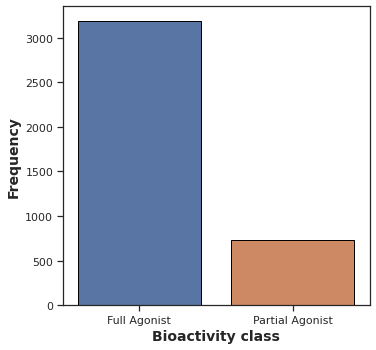

In [39]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_final, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

Scatter Plot

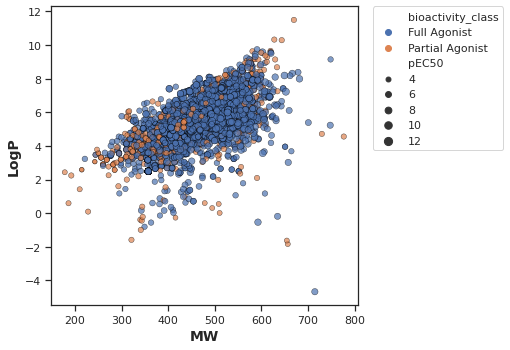

In [41]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='bioactivity_class', size='pEC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

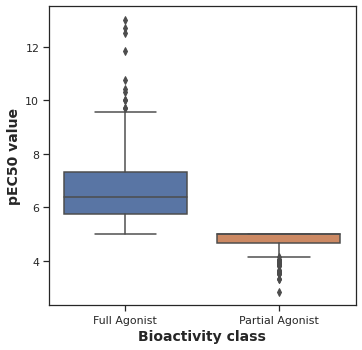

In [42]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pEC50', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pEC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

Mann Whitney U Test

In [43]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_final[selection]
  FullA = df[df.bioactivity_class == 'Full agonist']
  FullA = FullA[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_final[selection]
  PartialA = df[df.bioactivity_class == 'Partial Agonist']
  PartialA = PartialA[descriptor]

# compare samples
  stat, p = mannwhitneyu(FullA, PartialA)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [44]:
mannwhitney('pEC50')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,pEC50,0.0,0.0,0.05,Different distribution (reject H0)


Molecula Weight

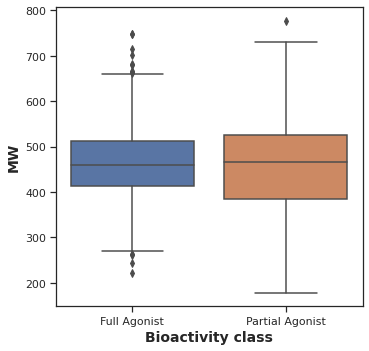

In [45]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [46]:
mannwhitney('MW')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,MW,0.0,0.0,0.05,Different distribution (reject H0)


LogP

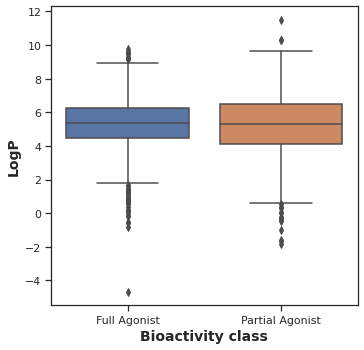

In [47]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [48]:
mannwhitney('LogP')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,0.0,0.0,0.05,Different distribution (reject H0)


Number of H Donors

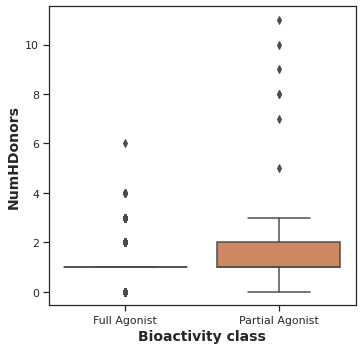

In [49]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [50]:
mannwhitney('NumHDonors')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,0.0,0.0,0.05,Different distribution (reject H0)


Number of H acceptors

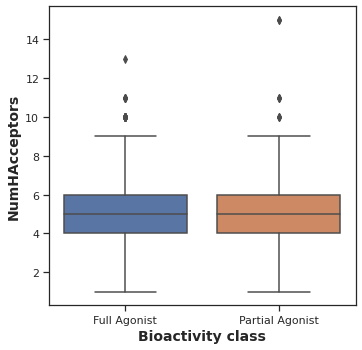

In [52]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')



In [53]:
mannwhitney('NumHAcceptors')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,0.0,0.0,0.05,Different distribution (reject H0)


In [55]:
df_final.to_csv('PPARg_bioactivity_preprocessed_data_pEC50.csv', index=False)

In [56]:
! zip -r results.zip . -i *.csv *.pdf

updating: PPARg_bioactivity_data_preprocessed.csv (deflated 86%)
updating: plot_NumHDonors.pdf (deflated 38%)
updating: plot_MW_vs_LogP.pdf (deflated 2%)
updating: plot_bioactivity_class.pdf (deflated 38%)
updating: mannwhitneyu_MW.csv (deflated 11%)
updating: mannwhitneyu_pEC50.csv (deflated 13%)
updating: mannwhitneyu_NumHDonors.csv (deflated 13%)
updating: plot_MW.pdf (deflated 37%)
updating: plot_NumHAcceptors.pdf (deflated 38%)
updating: plot_ic50.pdf (deflated 37%)
updating: plot_LogP.pdf (deflated 37%)
updating: mannwhitneyu_NumHAcceptors.csv (deflated 13%)
updating: mannwhitneyu_LogP.csv (deflated 11%)
  adding: PPARg_bioactivity_preprocessed_data_pEC50.csv (deflated 82%)
